***Vorlesung 'Syntax natürlicher Sprachen'***

--- 
# Intro Vorlesung 8: Syntaxregeln komplexer Sätze und Verbalkomplex

In [1]:
import nltk

In [2]:
from nltk.parse.stanford import StanfordParser, StanfordDependencyParser
import os

PATH_TO_CORE = os.getenv("HOME") + os.sep + os.path.join("nltk_data", "stanford-corenlp-full-2018-10-05")
PATH_TO_GER_MODEL = os.getenv("HOME") + os.sep + os.path.join("nltk_data", "stanford-models-2018-10-05")

jar = os.path.join(PATH_TO_CORE, "stanford-corenlp-3.9.2.jar")
model = os.path.join(PATH_TO_CORE,"stanford-corenlp-3.9.2-models.jar")
ger_model = os.path.join(PATH_TO_GER_MODEL, "stanford-german-corenlp-2018-10-05-models.jar")

stanford_parser = StanfordParser(jar, model, model_path="edu/stanford/nlp/models/lexparser/" + "englishPCFG.ser.gz")
stanford_ger_parser = StanfordParser(jar, ger_model, model_path="edu/stanford/nlp/models/lexparser/" + "germanPCFG.ser.gz")

stanford_dep_parser = StanfordDependencyParser(jar, model, model_path="edu/stanford/nlp/models/lexparser/" + "englishPCFG.ser.gz")
stanford_ger_dep_parser = StanfordDependencyParser(jar, ger_model, model_path="edu/stanford/nlp/models/lexparser/" + "germanPCFG.ser.gz")

In [3]:
import spacy
from spacy import displacy
nlp = spacy.load('de_core_news_sm')

In [4]:
from nltk import DependencyGraph
from nltk.tree import Tree
from itertools import chain


### tree_labeled-Methode für DependencyGraphs (pretty_print-Dependenzbäume mit Labels):
def _tree_labeled(self, i):
        node = self.get_by_address(i)
        word = node["word"]
        rel = node["rel"]        
        deps = sorted(chain.from_iterable(node["deps"].values()))

        if deps:
            return Tree(word+'('+rel+')', [self._tree_labeled(dep) for dep in deps])
        else:
            return word+'('+rel+')'
        
def tree_labeled(self):
        node = self.root

        word = node["word"]
        rel = node["rel"]
        deps = sorted(chain.from_iterable(node["deps"].values()))
        return Tree(word+'('+rel+')', [self._tree_labeled(dep) for dep in deps])

    
DependencyGraph._tree_labeled = _tree_labeled
DependencyGraph.tree_labeled = tree_labeled

In [5]:
#Konvertierungsfunktion von conll(4)-Format (MALT-tabular) für Rendering mit displaCy:
def displacy_dep_input(sent):
    deps = []
    for dep in sent.split('\n'):
        deps.append(dep.split())

    deps = [x for x in deps if x]

    ex = []
    word_list = []
    arc_list = []

    for index, dep in enumerate(deps):
        word_list.append({"text": dep[0], "tag": ""})
        line = index+1
        head = int(dep[2])
        label = dep[3]
        if head>line:
            start = index
            end = head-1
            direction = "left"
        else:
            start = head-1
            end = index  
            direction = "right"
        if(label.lower() != "root"):
            arc_list.append({"start": start, "end": end, "label": label, "dir": direction})

    ex.append({
        "words": word_list,
        "arcs": arc_list
    })    

    return ex

#html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

## Label:
- TIGER-DEPENDENCY-LABEL: https://www.linguistik.hu-berlin.de/de/institut/professuren/korpuslinguistik/mitarbeiter-innen/hagen/DDB_edge
- UD-LABEL: https://universaldependencies.org/u/dep/


- PENN-TREEBANK: http://www.surdeanu.info/mihai/teaching/ista555-fall13/readings/PennTreebankConstituents.html#Clause


--- 

---


---
## Objektsatz  (a) 

In [6]:
sentence = "ich glaube dass du lügst"

### *Konstituentenanalyse:*

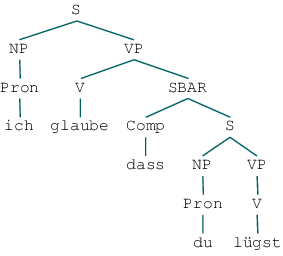

In [7]:
grammar = nltk.CFG.fromstring("""
 S -> NP VP
 NP -> Pron
 VP -> V
 
 VP -> V SBAR
 SBAR -> Comp S

 Pron -> 'ich' | 'du'
 Comp -> 'dass'
 V -> 'glaube' | 'lüge' | 'glaubst' | 'lügst'
""")

parser = nltk.ChartParser(grammar,trace=0)

sent = sentence.split()

for tree in parser.parse(sent):
#    tree.pretty_print(unicodelines=True)
    display(tree)

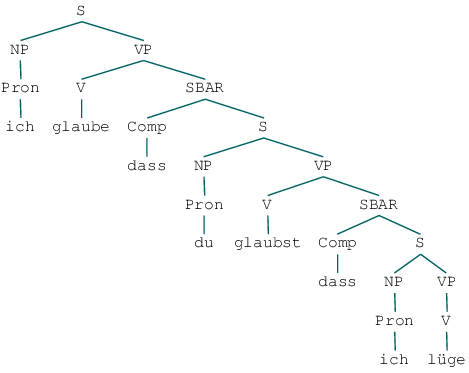

In [8]:
sentence = "ich glaube dass du glaubst dass ich lüge"

sent = sentence.split()

for tree in parser.parse(sent):
#    tree.pretty_print(unicodelines=True)
    display(tree)

---
### *Dependenzanalyse UD:*

In [9]:
sent = """ich _ 2 nsubj  
glaube _ 0 ROOT
dass _ 5 mark
du _ 5 nsubj
lügst – 2 ccomp
"""

dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

           glaube(ROOT)                       
    ┌───────────┴────────────┐                 
    │                   lügst(ccomp)          
    │           ┌────────────┴───────────┐     
ich(nsubj)  dass(mark)               du(nsubj)



In [10]:
print(spacy.explain('ccomp'), spacy.explain('mark'), sep="\n")

clausal complement
marker


---
### *Dependenzanalyse TIGER:*

In [11]:
sent = """ich _ 2 sb  
glaube _ 0 ROOT
dass _ 5 cp
du _ 5 sb
lügst – 2 oc
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True) 

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

        glaube(ROOT)                 
   ┌─────────┴───────────┐            
   │                 lügst(oc)       
   │         ┌───────────┴───────┐    
ich(sb)   dass(cp)             du(sb)



In [12]:
print(spacy.explain('oc'), spacy.explain('cp'), sep="\n")

clausal object
complementizer


---

---


---
## Infinitiv-Objektsatz  (b) 

- *überzeugen*: Objektkontrolle (Objekt des Hauptsatzes ist semantisches Subjekt des Infinitivsatzes)
- (dagegen z.B. *versprechen*: Subjektkontrolle)

In [13]:
sentence = "sie überzeugen ihn zu fahren"

### *Konstituentenanalyse:*

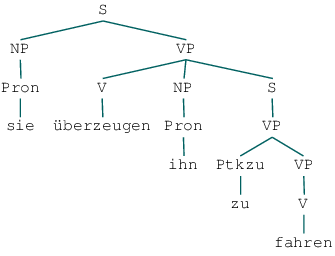

In [14]:
grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> Pron
VP -> V

VP -> V NP S
##subjektloser Satz (Infinitiv-Satz):
S -> VP
VP -> Ptkzu VP


Ptkzu -> 'zu'
Pron -> 'sie' | 'ihn'
V -> 'überzeugen' | 'fahren'
""")

parser = nltk.ChartParser(grammar,trace=0)

sent = sentence.split()

for tree in parser.parse(sent):
#    tree.pretty_print(unicodelines=True)
    display(tree)

---
### *Dependenzanalyse UD:*

In [15]:
sent = """sie _ 2 nsubj  
überzeugen _ 0 ROOT
ihn _ 2 obj
zu _ 5 mark
fahren _ 2 xcomp
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

           überzeugen(ROOT)              
    ┌─────────────┼───────────────┐       
    │             │         fahren(xcomp)
    │             │               │       
sie(nsubj)     ihn(obj)        zu(mark)  



In [16]:
print(spacy.explain('xcomp'), spacy.explain('mark'), sep="\n")

open clausal complement
marker


---
### *Dependenzanalyse TIGER:*

In [17]:
sent = """sie _ 2 sb  
überzeugen _ 0 ROOT
ihn _ 2 oa
zu _ 5 pm
fahren _ 2 oc
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})


        überzeugen(ROOT)           
   ┌───────────┼─────────────┐      
   │           │         fahren(oc)
   │           │             │      
sie(sb)     ihn(oa)        zu(pm)  



In [18]:
print(spacy.explain('oc'), spacy.explain('pm'), sep="\n")

clausal object
morphological particle


--- 

---



---
## Relativsatz  (c) 

In [19]:
sentence = "der Mann der zu viel wusste"

### *Konstituentenanalyse:*

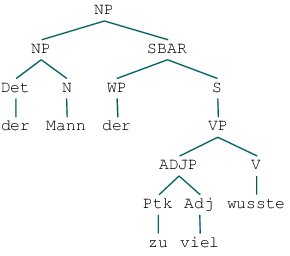

In [20]:
grammar = nltk.CFG.fromstring("""
NP -> NP SBAR
NP -> Det N
SBAR -> WP S

S -> VP
VP -> ADJP V

ADJP -> Ptk Adj

S -> NP VP

Det -> 'der'
N -> 'Mann'
WP -> 'der'
V -> 'wusste'
Ptk -> 'zu'
Adj -> 'viel'

""")

parser = nltk.ChartParser(grammar,trace=0)

sent = sentence.split()

for tree in parser.parse(sent):
#    tree.pretty_print(unicodelines=True)
    display(tree)

---
### *Dependenzanalyse UD:*

In [21]:
sent = """der _ 2 det
Mann NN 0 ROOT
der WP 6 nsubj
zu RB 5 advmod
viel _ 6 advmod
wusste – 2 acl:relcl
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

         Mann(ROOT)                               
   ┌─────────┴──────────────┐                      
   │                wusste(acl:relcl)             
   │         ┌──────────────┴──────────────┐       
   │         │                        viel(advmod)
   │         │                             │       
der(det) der(nsubj)                    zu(advmod) 



In [22]:
print(spacy.explain('acl'), spacy.explain('relcl'), sep="\n")

clausal modifier of noun (adjectival clause)
relative clause modifier


---
### *Dependenzanalyse TIGER:*

In [23]:
sent = """der _ 2 nk
Mann NN 0 ROOT
der WP 6 sb
zu RB 5 mo
viel _ 6 mo
wusste – 2 rc
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

        Mann(ROOT)                    
   ┌────────┴──────────┐               
   │               wusste(rc)         
   │        ┌──────────┴─────────┐     
   │        │                 viel(mo)
   │        │                    │     
der(nk)  der(sb)               zu(mo) 



In [24]:
print(spacy.explain('rc'), sep="\n")

relative clause


---

---


---
## Koordination  (d) 

In [25]:
sentence = "sie kamen und sie sahen"

### *Konstituentenanalyse:*

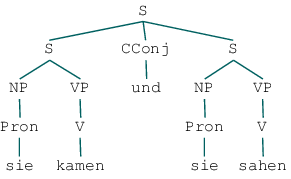

In [26]:
grammar = nltk.CFG.fromstring("""
S -> S CConj S
S -> NP VP
NP -> Pron
VP -> V

Pron -> 'sie'
V -> 'kamen' | 'sahen'
CConj -> 'und'
""")

parser = nltk.ChartParser(grammar,trace=0)

sent = sentence.split()

for tree in parser.parse(sent):
#    tree.pretty_print(unicodelines=True)
    display(tree)

---
### *Dependenzanalyse UD:*

In [27]:
sent = """sie _ 2 nsubj
kamen _ 0 ROOT
und _ 2 cc
sie _ 5 nsubj
sahen _ 2 conj
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

           kamen(ROOT)            
    ┌───────────┼───────────┐      
    │           │      sahen(conj)
    │           │           │      
sie(nsubj)   und(cc)    sie(nsubj)



In [28]:
print(spacy.explain('cc'), spacy.explain('conj'), sep="\n")

coordinating conjunction
conjunct


---
### *Dependenzanalyse TIGER:*

In [29]:
sent = """sie _ 2 sb
kamen _ 0 ROOT
und _ 2 cd
sie _ 5 sb
sahen _ 3 cj
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

        kamen(ROOT)          
   ┌─────────┴──────────┐     
   │                 und(cd) 
   │                    │     
   │                sahen(cj)
   │                    │     
sie(sb)              sie(sb) 



In [30]:
print(spacy.explain('cd'), spacy.explain('cj'), sep="\n")

coordinating conjunction
conjunct


--- 

---



---
## Auxiliar + Kopula = komplexe VP  (e) 

In [31]:
sentence = "das kann nicht richtig sein"

### *Konstituentenanalyse:*

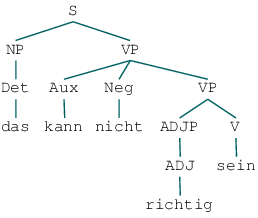

In [32]:
grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> Det
VP -> Aux Neg VP
VP -> ADJP V
ADJP -> ADJ

Det -> 'das'
Aux -> 'kann'
Neg -> 'nicht'
V -> 'sein'
ADJ -> 'richtig'
""")

parser = nltk.ChartParser(grammar,trace=0)

sent = sentence.split()

for tree in parser.parse(sent):
#    tree.pretty_print(unicodelines=True)
    display(tree)

---
### *Dependenzanalyse UD:*

In [33]:
sent = """das _ 4 nsubj
kann _ 4 aux
nicht _ 4 neg
richtig _ 0 ROOT
sein _ 4 cop
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

           richtig(ROOT)                     
    ┌────────────┼───────────┬──────────┐     
das(nsubj)   kann(aux)   nicht(neg) sein(cop)



In [34]:
print(spacy.explain('aux'), spacy.explain('cop'), spacy.explain('neg'), sep="\n")

auxiliary
copula
negation modifier


---
### *Dependenzanalyse TIGER:*

In [35]:
sent = """das _ 2 sb
kann _ 0 ROOT
nicht _ 2 ng
richtig _ 5 pd 
sein _ 2 oc
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

        kann(ROOT)            
   ┌────────┼───────────┐      
   │        │        sein(oc) 
   │        │           │      
das(sb) nicht(ng)  richtig(pd)



In [36]:
print(spacy.explain('oc'), spacy.explain('pd'), spacy.explain('ng'), sep="\n")

clausal object
predicate
negation


---

---


---
## Adverbialer Nebensatz  (f) 

In [37]:
sentence = "als der Sturm begann fror sie"

### *Konstituentenanalyse:*

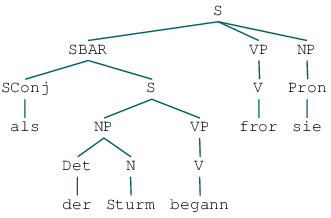

In [38]:
grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> Det N
VP -> V
NP -> Pron

S -> SBAR VP NP
SBAR -> SConj S

SConj -> 'als'
Det -> 'der'
N -> 'Sturm'
Pron -> 'sie'
V -> 'fror' | 'begann'
""")

parser = nltk.ChartParser(grammar,trace=0)

sent = sentence.split()

for tree in parser.parse(sent):
#    tree.pretty_print(unicodelines=True)
    display(tree)

---
### *Dependenzanalyse UD:*

In [39]:
sent = """als _ 4 mark
der _ 3 det
Sturm _ 4 nsubj
begann _ 5 advcl
fror _ 0 ROOT
sie – 5 nsubj
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

           fror(ROOT)                           
    ┌──────────┴────────────┐                    
    │                 begann(advcl)             
    │          ┌────────────┴────────────┐       
    │          │                    Sturm(nsubj)
    │          │                         │       
sie(nsubj) als(mark)                  der(det)  



In [40]:
print(spacy.explain('advcl'), spacy.explain('mark'), sep="\n")

adverbial clause modifier
marker


---
### *Dependenzanalyse TIGER:*

In [41]:
sent = """als _ 4 cp
der _ 3 nk
Sturm _ 4 sb
begann _ 5 mo
fror _ 0 ROOT
sie – 5 sb
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

        fror(ROOT)                     
   ┌────────┴──────────┐                
   │               begann(mo)          
   │        ┌──────────┴──────────┐     
   │        │                 Sturm(sb)
   │        │                     │     
sie(sb)  als(cp)               der(nk) 



In [42]:
print(spacy.explain('mo'), spacy.explain('cp'), sep="\n")

modifier
complementizer


--- 

---



---

---


---
## Infinitiv-Subjektsatz  (g) 

In [43]:
sentence = "zu gehen wäre falsch"

### *Konstituentenanalyse:*

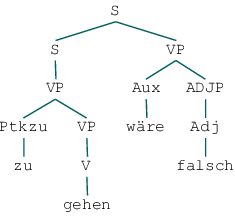

In [44]:
grammar = nltk.CFG.fromstring("""
S -> S VP

S -> VP
VP -> Ptkzu VP
VP -> Aux VP

VP -> V
VP -> Aux ADJP
ADJP -> Adj

Ptkzu -> 'zu'
V -> 'gehen'
Aux -> 'wäre'
Adj -> 'falsch'
""")

parser = nltk.ChartParser(grammar,trace=0)

sent = sentence.split()

for tree in parser.parse(sent):
#    tree.pretty_print(unicodelines=True)
    display(tree)

---
### *Dependenzanalyse UD:*

In [45]:
sent = """zu _ 2 mark
gehen _ 4 csubj
wäre _ 4 aux
falsch _ 0 ROOT
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

          falsch(ROOT)             
    ┌──────────┴────────────┐       
    │                  gehen(csubj)
    │                       │       
wäre(aux)                zu(mark)  



In [46]:
print(spacy.explain('csubj'), spacy.explain('mark'), spacy.explain('aux'), sep="\n")

clausal subject
marker
auxiliary


---
### *Dependenzanalyse TIGER:*

In [47]:
sent = """zu _ 2 pm
gehen _ 3 sb
wäre _ 0 ROOT
falsch _ 3 pd
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

           wäre(ROOT)          
    ┌──────────┴──────────┐     
    │                 gehen(sb)
    │                     │     
falsch(pd)              zu(pm) 



In [48]:
print(spacy.explain('sb'), spacy.explain('pm'), spacy.explain('pd'), sep="\n")

subject
morphological particle
predicate


---

---


---
## Subjektsatz  (Zusatz) 

In [49]:
sentence = "dass jemand geht ist falsch"

### *Konstituentenanalyse:*

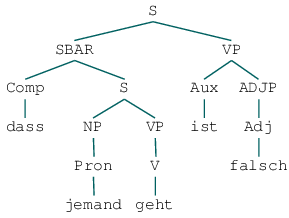

In [50]:
grammar = nltk.CFG.fromstring("""
S -> NP VP
NP -> Pron
VP -> V

S -> SBAR VP
SBAR -> Comp S

VP -> Aux ADJP
ADJP -> Adj

Comp -> 'dass'
V -> 'geht'
Aux -> 'ist'
Adj -> 'falsch'
Pron -> 'jemand'
""")

parser = nltk.ChartParser(grammar,trace=0)

sent = sentence.split()

for tree in parser.parse(sent):
#    tree.pretty_print(unicodelines=True)
    display(tree)

---
### *Dependenzanalyse UD:*

In [51]:
sent = """dass _ 3 mark
jemand – 3 nsubj 
geht _ 5 csubj
ist _ 5 aux
falsch _ 0 ROOT
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

         falsch(ROOT)                          
   ┌──────────┴────────────┐                    
   │                  geht(csubj)              
   │          ┌────────────┴────────────┐       
ist(aux)  dass(mark)              jemand(nsubj)



In [52]:
print(spacy.explain('csubj'), spacy.explain('nsubj'), spacy.explain('mark'), spacy.explain('aux'), sep="\n")

clausal subject
nominal subject
marker
auxiliary


---
### *Dependenzanalyse TIGER:*

In [53]:
sent = """dass _ 3 cp
jemand – 3 sb 
geht _ 4 sb
ist _ 0 ROOT
falsch _ 4 pd
"""


dg = DependencyGraph(sent)
tree_labeled = dg.tree_labeled()
tree_labeled.pretty_print(unicodelines=True)   

ex = displacy_dep_input(sent)
html = displacy.render(ex, style="dep", manual=True, options={'distance':100})

           ist(ROOT)                    
    ┌──────────┴────────┐                
    │                geht(sb)           
    │          ┌────────┴─────────┐      
falsch(pd)  dass(cp)          jemand(sb)



In [54]:
print(spacy.explain('sb'), spacy.explain('cp'), spacy.explain('pd'), sep="\n")

subject
complementizer
predicate
